# LangGraph Pipeline with LangFuse

Import packages.

In [1]:
import os
import pandas as pd

from datetime import datetime
from dotenv import load_dotenv
from json import loads, dumps
from langchain.tools import tool


from typing import Annotated, Sequence, TypedDict, Literal

from IPython.display import Image, display


from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import ChatOpenAI

from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler
from langfuse.openai import openai  # Don't delete this line.

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

Set up environment variables.

In [2]:
# Set up environment variables.
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

# Monitor if the environment variables are ready.
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set - please head to the troubleshooting guide in the setup folder")

OpenAI API Key exists and begins sk-proj-


In [3]:
langfuse_secret_key = os.getenv('LANGFUSE_SECRET_KEY')
langfuse_public_key = os.getenv('LANGFUSE_PUBLIC_KEY')
langfuse = Langfuse(
    secret_key = langfuse_secret_key,
    public_key = langfuse_public_key,
    host="https://cloud.langfuse.com"
    # host = "https://us.cloud.langfuse.com"
)

langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [4]:
completion = openai.chat.completions.create(
  name="test-chat",
  model="gpt-4o",
  messages=[
      {"role": "system", "content": "You are a very accurate calculator. You output only the result of the calculation."},
      {"role": "user", "content": "1 + 1 = "}],
  metadata={"someMetadataKey": "someValue"},
)

Define supporting variables and functions.

In [5]:
def format_job_descriptions(jd_dataframe):
    if isinstance(jd_dataframe, pd.Series):
        jd_dataframe = jd_dataframe.to_frame().T
    result = jd_dataframe.to_json(orient='records')
    return result

Define Graph Sate.

In [6]:
class AgentState(TypedDict):
    """
    Represents the state of graph.

    Attributes:
        messages: A list of messages in the conversation, including user input and agent outputs.

    Notes:
        The add_messages function defines how an update should be processed.
        Default is to replace. add_messages says "append".
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

Deinfe Basic Nodes.

Input: job description strings.

Host node

Conditional Edge: whether the question is about to check job descriptions.

If not, return generate.

If yes, go to next node.

Get industry information and professional skills.

Get general requirements.

Evaluate the job advertisement.

Refine the job advertisement.



In [7]:
def host_agent(state):
    """
    Invokes the whole workflow and monitor the state.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    
    print("---CALL HOST AGENT---")
    messages = state["messages"][-1].content
    
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [8]:
def industry_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL INDUSTRY AGENT---")

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that extracts structured information from a given job advertisements.

            Input job ad:
            {job_text}

            Instruction:
            Extract the following fields from the given job advertisement. If a field is not present, return an empty list for that field.

            - skills: short list of skills, tools, technologies (e.g., "Python", "SQL", "scikit-learn", "communication")
            - responsibilities: short concise list of responsibilities / duties described in the ad
            - requirements: candidate requirements such as experience, qualifications, degrees, certifications, years of experience

            Return a JSON objects ONLY and MUST with keys: "job_title", "skills", "responsibilities", "requirements", "classification", "salary", "location", "workType".  

            Example:
            {{"job_title": ["Data Scientist"], "skills": ["Python", "SQL"], "responsibilities": ["build predictive models"], "requirements": ["3+ years experience", "Bachelor's degree"], "classification":["Information & Communication Technology"], "salary":["150,000 AUD"], "location":["Sydney"], "workType":["Fulltime"]}}
        """,
        input_variables=["job_text"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_text": config["configurable"]["job_ads"][-1]})
    return {"messages": [response]}

In [9]:
def check_task_agent(state, config) -> Literal["industry_agent", "END"]:
    """
    Determines whether the question is about to check job descriptions.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is about to check job descriptions.
    """

    print("---CHECK TASK RELEVANCE---")

    
    if config["configurable"]["job_ads"][-1] is not None and len(config["configurable"]["job_ads"][-1]) >= 1:
        print("---DECISION: This is a job advertisement analysis task. ---")
        return "industry_agent"

    else:
        print("---DECISION: This is not a job advertisement analysis task.---")
        print("PLEASE INPUT JOB DESCRIPTIONS.")
        return "END"

In [10]:
def evaluate_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL EVALUATE AGENT---")
    messages = state["messages"]
    job_message = messages[-1]
    job_message_docs = job_message.content

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that can evaluate the job advertisement information and give improve suggestions.

            Input job advertisement information:
            {job_message_docs}

            Instruction:
            Based on the current information, list the lacked part of job advertisement and the improved suggestion.
            
            Return a JSON object ONLY and MUST with keys: "skills_evaluate", "responsibilities_evaluate", "requirements_evaluate", "classification_evaluate", "salary_evaluate", "location_evaluate", "workType_evaluate". 

            No other strings outside JSON objects.

            Example:

            {{"skills_evaluate":["Can be more clear", "Python, SQL, GCP"], "salary_evaluate":["Missed", "Competitive Salary"], "location_evaluate":["Missed"], "workType_evaluate":["Missed"]}}
        """,
        input_variables=["job_message_docs"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_message_docs": job_message_docs})
    return {"messages": [response]}

Complie the graph.

In [11]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes.
workflow.add_node("host_agent", host_agent)  
workflow.add_node("industry_agent", industry_agent)  
workflow.add_node("evaluate_agent", evaluate_agent)  

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "host_agent")
workflow.add_conditional_edges(
    "host_agent", 
    check_task_agent, 
    {
        "END": END,                         # map this label to the END
        "industry_agent": "industry_agent", # map this one to a node
    })
workflow.add_edge("industry_agent", "evaluate_agent")
workflow.add_edge("evaluate_agent", END)

# Compile
graph = workflow.compile(checkpointer=MemorySaver())


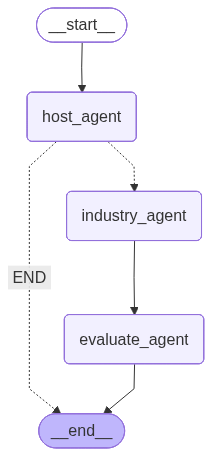

In [12]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [ ]:
def agent_invoke(graph, question, job_ads, config):
    """
    Invoke the workflow with user question, generate human-friendly metrics and answers.

    Args:
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse

    Returns:
        retriever_counter: how many times the retriever tool is called for this question
        rewrite_counter: how many times the question is rewritten, which indicates a failed retrieval
        final_message: the answer that can be shown to all audience
    """
    # config["configurable"]["questions"].append(question)
    config["configurable"]["job_ads"].append(job_ads)

    analysis_message = []
    evaluate_message = []

    inputs = {
        "messages":[
            ("user", question)
        ]
    }

    for output in graph.stream(inputs, config=config):
        for key, value in output.items():
            # For Agent node, output tool call information.
            if key == 'host_agent':
                print("host_agent")
                # final_message = final_message + value['messages'][0].content
                print(value['messages'][0].content)
            # For retrieve tool node, counter plus.
            elif key == 'industry_agent':
                print("industry_agent")
                # final_messsage = final_message + value['messages'][0]
                # print(value['messages'][0])
                analysis_message.append(value['messages'][0])

            elif key == 'evaluate_agent':
                print("evaluate_agent")
                # final_messsage = final_message + value['messages'][0]
                # print(value['messages'][0])
                evaluate_message.append(value['messages'][0])
                print("\n---END QUESTION---")
            else:
                pass
    return analysis_message, evaluate_message

In [14]:
def deal_with_single_question(logs, graph, question, job_ads, config):
    """
    Deal with the workflow inputs and outputs, push them into local logging system.

    Args:
        logs: the list to store key information and metrics for the whole thread
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse
    """
    # Get the current date and time for time stamp.
    invoke_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    thread_id = config['configurable']['thread_id']


    analysis_message, evaluate_message = agent_invoke(graph, question, job_ads, config)
    return invoke_datetime, thread_id, analysis_message, evaluate_message
    

Use case test.

In [15]:
# Put LangFuse Handler when the workflow is invoked.
# Set up functions.
langfuse_handler = CallbackHandler()

In [23]:
train_df = pd.read_csv("job-description-data/X_train.csv")
sample_df = train_df.sample(n=20, random_state=42)
sample_df.to_csv("job-description-data/sample_df.csv", index=False)

In [25]:
logs = []

for i in range(0, 20):
    if i%5 == 0:
        thread_id_str = "loop-test-"+str(i/5)
        config = {"configurable": {"thread_id": thread_id_str, "questions": [], "job_ads":[], "callbacks": [langfuse_handler]}}
        
    
    row_df = sample_df.iloc[i,:]
    json_records = row_df.to_json(orient='records')
    invoke_datetime, thread_id, analysis_message, evaluate_message = deal_with_single_question(logs, graph, "Hi, I'm Alexandra. Please help me analyse following job advertisements", json_records, config)
    if not analysis_message or not evaluate_message:
        continue
    analysis_dict = loads(analysis_message[0])
    analysis_df = pd.DataFrame([analysis_dict])
    evaluate_dict = loads(evaluate_message[0])
    evaluate_df = pd.DataFrame([evaluate_dict])
    single_result = pd.concat([analysis_df, evaluate_df], axis=1)
    single_result["invoke_datetime"] = invoke_datetime
    single_result["thread_id"] = thread_id
    logs.append(single_result)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is a job advertisement analysis task. ---
host_agent
Hello Alexandra! I'd be happy to help you analyze the job advertisements you have. Please provide the details of the job advertisements you'd like to discuss, and let me know what specific aspects you want to focus on (e.g., job requirements, qualifications, company culture, etc.).
---CALL INDUSTRY AGENT---
industry_agent
{
    "job_title": ["Business Services Senior Accountant"],
    "skills": ["Preparation of financial statements", "tax returns", "BAS", "FBT", "Payroll tax", "Journal entries", "reconciling accounts", "liaising with ATO and ASIC", "ad hoc advisory", "research work"],
    "responsibilities": ["Preparation of financial statements, tax returns, BAS, FBT, and Payroll tax", "Journal entries and reconciling accounts", "Liaising with the ATO, ASIC, and other bodies", "Ad hoc advisory and research work", "Mentor juniors and grads"],
    "requirements": ["CA 

In [26]:
log_df = pd.concat(logs, axis=0)
log_df

,job_title,skills,responsibilities,requirements,classification,salary,location,workType,skills_evaluate,responsibilities_evaluate,requirements_evaluate,classification_evaluate,salary_evaluate,location_evaluate,workType_evaluate,invoke_datetime,thread_id
0,[Business Services Senior Accountant],"[Preparation of financial statements, tax retu...","[Preparation of financial statements, tax retu...","[CA Qualified (or near completion), 4 - 5 year...","[Accounting, Business Services & Corporate Adv...",[],"[CBD, Inner West & Eastern Suburbs, Sydney]",[Full Time],[Consider adding software skills relevant to a...,[Clarify the extent of responsibility for ment...,[Specify if international candidates are eligi...,[No improvements needed],"[Salary range is missing, Include a competitiv...",[No improvements needed],[No improvements needed],20251025_201044,loop-test-0.0
0,[Area Manager - Victoria],"[leadership, time management, P&L management, ...","[Running and overseeing 3 - 5 ALDI stores, Man...",[Bachelor Degree or Master Degree in any disci...,"[CEO & General Management, General/Business Un...","[$112,000 - $162,800 + Car]",[Bairnsdale & Gippsland],[Full Time],"[Include soft skills specifics, Add skills lik...",[Specify frequency or conditions for responsib...,[Specify desired industries for business exper...,[Clarify the level of seniority within the 'CE...,"[Include benefits or bonuses if applicable, Cl...","[Specify if relocation support is available, M...",[Detail expected working hours or any potentia...,20251025_201056,loop-test-0.0
0,[Maths & Physics Teacher],"[teaching Maths and Physics, Middle Years Scie...","[teach Maths and Physics from Years 7 - 12, co...",[teacher registration in QLD or eligibility to...,"[Education & Training, Teaching - Secondary]",[],"[Toowoomba, QLD]",[Full Time],[Add specific teaching methodologies or techno...,[Include specific extracurricular activities o...,"[Specify years of experience required, Mention...",[No improvements needed],"[Missed, Include a salary range or state that ...",[No improvements needed],[No improvements needed],20251025_201110,loop-test-0.0
0,[Drug Intervention and Rehabilitation Worker],"[crisis intervention, case management, communi...","[engage, support and educate homeless and at-r...","[tertiary qualification in Social Work, Psycho...","[Community Services & Development, Community D...",[],"[CBD & Inner Suburbs, Brisbane, Fortitude Valley]",[Full Time],[Consider adding more specific skills such as ...,[Responsibilities are well-defined. Consider a...,[Requirements are comprehensive. It might be h...,[Classification is appropriate. No changes nee...,[Salary information is missing. Suggest adding...,[Location is clearly stated. No changes needed.],[Work type is specified as 'Full Time'. No cha...,20251025_201118,loop-test-0.0
0,"[Customer Service Officer, Level 1]","[problem-solving, customer service, time manag...",[provide end-to-end services to improve custom...,"[strong emotional resilience, ability to adjus...",[Call Centre & Customer Service],[],"[Wellington Central, Wellington, Wellington CBD]",[Contract/Temp],[Add more specific skills related to digital t...,[Include more detailed responsibilities such a...,[Specify the required level of experience in c...,[Classification is clear.],"[Salary information is missing., Provide a sal...",[Location is clearly specified.],[Specify the duration of the contract or if th...,20251025_201130,loop-test-0.0
0,[Legal Executive Assistant],"[email management, diary management, schedulin...","[High level email management, Proactively mana...",[4+ years experience as a Legal Secretary supp...,[Legal],[],"[CBD, Inner & Western Suburbs, Perth]",[Full Time],[Include proficiency levels for software skill...,[Specify frequency or volume of tasks where po...,"[Specify educational qualifications required, ...",[Add more specific sub-classifications if appl...,"[Salary information is missing, Provide a sala...",[Location is specified adequa

In [27]:
log_df.shape

(20, 17)

In [28]:
# Construct the filename with the datetime suffix and thread id.
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"job-description-logs/loop_test_full_{current_time}.csv"

# Save the DataFrame to CSV file.
log_df.to_csv(filename, index=False) 
print(f"Save log for this thread to {filename}")

Save log for this thread to job-description-logs/loop_test_full_20251025_201551.csv
